# ANEXO 1: CÓDIGO EN PYTHON PARA REPLICAR, CORREGIR, ADAPTAR...

## 1) Instalaciones e Importaciones de Librerías Previas:

- Instalamos el módulo necesario para leer la base de datos, que se proporcionan en SPSS

In [1]:
!pip install pyreadstat

- Instalamos el módulo necesario para hacer el análisis factorial

In [2]:
!pip install factor-analyzer==0.3.2

In [3]:
!pip install semopy

In [4]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


- Importamos las librerías necesarias:

In [5]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from typing import List
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)
from scipy.stats import chi2, pearsonr
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, TransformerMixin
from factor_analyzer.rotator import Rotator
from factor_analyzer.rotator import POSSIBLE_ROTATIONS, OBLIQUE_ROTATIONS
from sklearn.utils.extmath import randomized_svd
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from typing import List
from semopy import Model
from semopy import Optimizer
from semopy.inspector import inspect
from semopy.stats import calculate_p_values
from semopy import calc_aic
from semopy import calc_likelihood
from semopy import gather_statistics
from semopy.model_generator import generate_model
import statsmodels.api as sm           
import statsmodels.formula.api as smf
from matplotlib import pyplot             # Permite la generación de gráficos
from mpl_toolkits.mplot3d import Axes3D

In [6]:
import graphviz as gv

In [7]:
import semopy.visualization as sv

## 2) Cargamos bases de datos de la ola 6 y la ola 8 de ELSA

- Ola 6

In [8]:
w6_df: pd.core.frame.DataFrame = pd.read_spss('data/wave_6_elsa_data_v2.sav', convert_categoricals = False)

- Ola 8

In [9]:
w8_df: pd.core.frame.DataFrame = pd.read_spss('data/wave_8_elsa_data_eul_v2.sav', convert_categoricals = False)

Hacemos que las filas se llamen como el número de identificación único _indaunic_ de los sujetos

In [10]:
w6_df = w6_df.set_index('idauniq')

In [11]:
w8_df = w8_df.set_index('idauniq')

## 3) Construcción teórica de Cuestionarios

Estructura y columnas de la base de datos general que los componen

### 3.1) Ola 6

- Casp-19 para la ola 6 -> casp19_w6

In [12]:
casp19_w6_control = ['scqola', 'scqolb', 'scqolc', 'scqold']
casp19_w6_autonomy = ['scqole', 'scqolf', 'scqolg', 'scqolh', 'scqoli']
casp19_w6_pleasure = [ 'scqolj', 'scqolk', 'scqoll', 'scqolm', 'scqoln']
casp19_w6_self_realization = ['scqolo', 'scqolp', 'scqolq', 'scqolr', 'scqols']

casp19_w6_scales = [casp19_w6_control, casp19_w6_autonomy, casp19_w6_pleasure, casp19_w6_self_realization]

casp19_original_values = [1, 2, 3, 4]
casp19_reverse_items_values = [0, 1, 2, 3]
casp19_direct_items_values = [3, 2, 1, 0]

* Insatisfacción sexual para la ola 6 

In [13]:
sexdissa_w6_f_cols = ['q3', 'q9', 'q10', 'q14f', 'q15f', 'q19m19f', 'q28m25f', 'q32m26f']
sexdissa_w6_m_cols = ['q3', 'q9', 'q10', 'q13m', 'q17m', 'q19m19f', 'q21m', 'q28m25f', 'q32m26f']

sexdissa_item_to_transform = ['q10'] # female and male
sexdissa_direct_items_f = ['q3', 'q9', 'q14f', 'q15f', 'q19m19f', 'q28m25f', 'q32m26f'] # female
sexdissa_direct_items_m =  ['q3', 'q9', 'q13m', 'q17m', 'q19m19f', 'q21m', 'q28m25f', 'q32m26f'] # male
sexdissa_w6_q10_original_values = [1, 2, 3]
sexdissa_w6_q10_transformed_values = [5, 0, 5]

- Isolation para la ola 6 -> isolation_w6_df

Nomenclatura: 
>`vip`: persona/s importantes: children, family y friends.

>`has_vip`: tiene a esa persona/personas importantes. Es decir, tiene niños, familia, amigos.

In [14]:
isolation_w6_chd_items = {
    'has_vip': ['scchd'],
    'kind_of_contact': ['scchdg', 'scchdh', 'scchdi', 'scchdt'],
}
isolation_w6_fam_items = {
    'has_vip': ['scfam'],
    'kind_of_contact': ['scfamg', 'scfamh', 'scfami', 'scfamt'],
}
isolation_w6_frd_items = {
    'has_vip': ['scfrd'],
    'kind_of_contact': ['scfrdg', 'scfrdh', 'scfrdi', 'scfrdt'],
}

isolation_w6_org_contact = 'scorg09'
isolation_w6_prt_contact = 'scprtr'

isolation_w6_relatives = [isolation_w6_chd_items, isolation_w6_fam_items, isolation_w6_frd_items]

* multimorbidity

Si la persona confirma que la enfermedad registrada en el pasado está correctamente registrada (hedac-/hedbd- = yes) y que aún la tiene (hedas-/hedbs- = yes) o bien desmiente que le tuviera (hedac-/hedbd- = No) pero dice tenerla ahora ((hedan-/hedbm- = 3) o la reporta ahora (hedia-/hedib- = 1 "mentioned") entonces se imputará un uno sobre esa enfermedad. Si, en suma, hay más de un uno se asignará un uno a la variable de comorbilidad. 

In [15]:
cvd = ['bp', 'an', 'mi', 'hf', 'hm', 'ar', 'di', 'st', 'ch', '95']
chr_ = ['lu', 'as', 'ar', 'os', 'ca', 'pd', 'ps', 'ad', 'de', 'bl'] # ps: psychiatric
psy = ['ha', 'an', 'de', 'em', 'sc', 'ps', 'mo', 'ma']

lex_diagnosed_fedforward_cvd = 'hedaw' 
lex_diagnosed_fedforward_chr = 'hedbw'
# hedaw- y hedbw- puede que no las necesite

lex_what_psy = 'hepsy'

lex_confirm_cvd = 'hedac'
lex_confirm_chr = 'hedbd'

lex_still_has_cvd = 'hedas'
lex_still_has_chr = 'hedbs'

lex_dispute_cvd = 'hedan'
lex_dispute_chr = 'hedbm'
       
lex_new_cvd = 'hedia'
lex_new_chr = 'hedib'

In [16]:
diagnosed_fedforward_cvd = [lex_diagnosed_fedforward_cvd + i for i in cvd]
diagnosed_fedforward_chr = [lex_diagnosed_fedforward_chr + i for i in chr_]

what_psy = [lex_what_psy + i for i in psy]

still_has_cvd = [lex_still_has_cvd + i for i in cvd]
still_has_chr = [lex_still_has_chr + i for i in chr_]


confirm_cvd = [lex_confirm_cvd + i for i in cvd]
confirm_chr = [lex_confirm_chr + i for i in chr_]


dispute_cvd = [lex_dispute_cvd + i for i in cvd]
dispute_chr = [lex_dispute_chr + i for i in chr_]
       
new_cvd = [lex_new_cvd + i for i in cvd]
new_chr = [lex_new_chr + i for i in chr_]

### 3.2) Ola 8

- Casp-19 para la ola 8 -> casp19_w8

In [17]:
casp19_w8_control = ['scqola', 'scqolb', 'scqolc', 'scqold']
casp19_w8_autonomy = ['scqole', 'scqolf', 'scqolg', 'scqolh', 'scqoli']
casp19_w8_pleasure = [ 'scqolj', 'scqolk', 'scqoll', 'scqolm', 'scqoln']
casp19_w8_self_realization = ['scqolo', 'scqolp', 'scqolq', 'scqolr', 'scqols']

casp19_w8_scales = [casp19_w6_control, casp19_w6_autonomy, casp19_w6_pleasure, casp19_w6_self_realization]

casp19_original_values = [1, 2, 3, 4]
casp19_reverse_items_values = [0, 1, 2, 3]
casp19_w8_direct_items_values = [3, 2, 1, 0]

## 4) Tratamiento de valores perdidos de los primeros cuestionarios:

Lo hacemos de esta manera para teneer la mayor cantidad de sujetos posible a la hora de hacer los análisis factoriales 

### 4.1) Ola 6

- Casp19 e Isolation: **"-2": "schedule not aplicable"** :  *Cuestionarios, compuestos por sus ítems, que van a ser revisados para eliminar sujetos que no formaban parte de la muestra en estos módulos de ELSA. 1604 sujetos no han recibido este módulo del cuestionario* 

#### Columnas, pertenecientes a cuestionarios, que van a ser limpiadas

In [18]:
isolation_w6_cols = ['scchdg', 'scchdh', 'scchdi', 'scchdt', 
                     'scfamg', 'scfamh', 'scfami', 'scfamt', 
                     'scfrdg', 'scfrdh', 'scfrdi', 'scfrdt', 
                     'scorg09', 
                     'scprtr']
casp19_w6_cols = ['scqola', 'scqolb', 'scqolc', 'scqold', 'scqole', 
               'scqolf', 'scqolg', 'scqolh', 'scqoli', 'scqolj', 
               'scqolk', 'scqoll', 'scqolm', 'scqoln', 'scqolo', 
               'scqolp', 'scqolq', 'scqolr', 'scqols']

In [19]:
cols_to_clean_out_of_sample_w6 = isolation_w6_cols + casp19_w6_cols

#### sujetos seleccionados para ser eliminados 

traducción: 
> Constrúyeme una variable (llamada sbj_out_of_sample) que sea igual a: me localizas en el dataframe w6_df `w6_df.loc` lo que te voy a decir: `[` construye un pandas dataframe `pd.DataFrame` con lo siguiente `(`: mira cuales cumplen `==` que son un elemento del w6_df igual a -2 `)` (eso devuelve un True o False) y hazlo para `for` cada elemento `col` en `in` la variable cols_to_clean_out_of_sample (ya definida). Hazlo si en esta lista `[]` lo hay en ALGUNA (de las columnas)`any()`. Bien, cuando lo tengas localizado `]`, coge el índice `.index()`.

In [20]:
sbj_out_of_sample_w6 = w6_df.loc[pd.DataFrame([(w6_df[col] == -2) for col in cols_to_clean_out_of_sample_w6]).any()].index
sbj_out_of_sample_w6 # Resultado: Int64Index([5, 9, 16, 17, 18, 19, 62, 65, 71, 89, 91, 93, 96], dtype='int64')

Float64Index([100021.0, 100023.0, 100025.0, 100032.0, 100052.0, 100055.0,
              100058.0, 100061.0, 100066.0, 100091.0,
              ...
              166144.0, 166145.0, 166151.0, 166156.0, 166159.0, 166162.0,
              166163.0, 700108.0, 702643.0, 703440.0],
             dtype='float64', name='idauniq', length=1604)

#### Construimos el dataframe sin los sujetos
traducción:
>Construye una variable (tipo df por cómo se compone) que sea: el dataframe w6_df quitándole `.drop` los sujetos seleccionados.

In [21]:
w6_without_sbj_out_of_sample_df =  w6_df.drop(sbj_out_of_sample_w6)
w6_without_sbj_out_of_sample_df #del 88 pasa al 90 y luego al 92 porque el 89 y el 91 se eliminaron

,idahhw6,perid,samptyp,w6indout,W6hhout,couple,cpid,chinhh,chouthh,gcinhh,...,w6nssec8,w6nssec5,w6nssec3,W6SIC,w6soc,W6SEC,w6sic2003,w6soc2000,w6nssec13,finstatw6
idauniq,,,,,,,,,,,,,,,,,,,,,
100006.0,10656.0,3.0,3.0,11.0,110.0,1.0,1.0,2.0,1.0,2.0,...,6.0,5.0,3.0,1.0,1.0,1.0,89.0,82.0,12.3,5.0
100007.0,15127.0,4.0,3.0,11.0,110.0,2.0,1.0,2.0,1.0,2.0,...,3.0,2.0,2.0,0.0,0.0,0.0,-1.0,41.0,7.1,5.0
100009.0,11311.0,3.0,3.0,11.0,110.0,2.0,1.0,2.0,1.0,2.0,...,7.0,5.0,3.0,0.0,0.0,0.0,-1.0,81.0,13.4,5.0
100026.0,14166.0,4.0,3.0,11.0,110.0,2.0,2.0,2.0,1.0,2.0,...,4.0,3.0,2.0,0.0,0.0,0.0,-1.0,52.0,8.1,5.0
100039.0,12254.0,3.0,3.0,11.0,110.0,1.0,1.0,2.0,1.0,2.0,...,4.0,3.0,2.0,0.0,0.0,0.0,-1.0,12.0,9.1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701951.0,14705.0,1.0,1.0,11.0,120.0,1.0,2.0,2.0,1.0,2.0,...,7.0,5.0,3.0,0.0,0.0,0.0,-1.0,-3.0,13.4,7.0
704339.0,16697.0,2.0,1.0,11.0,110.0,3.0,-1.0,2.0,2.0,2.0,...,6.0,5.0,3.0,0.0,0.0,0.0,-1.0,81.0,12.4,7.0
705145.0,11528.0,2.0,3.0,11.0,110.0,2.0,1.0,2.0,2.0,2.0,...,2.0,1.0,1.0,0.0,0.0,0.0,-1.0,34.0,4.3,13.0


- Isolation: **kind_of_contact = "-1" "item not applicable" y has_vip = "-9" "not answered"**: *sujetos que van a ser eliminados porque no contestaron a si tenían VIP y el ítem de tipo de contacto no es aplicable*

#### Columnas que se van a inspeccionar para ver qué sujetos cumplen las condiciones para ser eliminados:

In [22]:
cols_to_clean_didnt_awr_hasvip_w6 = ['scchd', 'scfam', 'scfrd']
cols_to_clean_kind_of_contact_not_applicable_w6 = [['scchdg', 'scchdh', 'scchdi', 'scchdt'], 
                                                ['scfamg', 'scfamh', 'scfami', 'scfamt'], 
                                                ['scfrdg', 'scfrdh', 'scfrdi', 'scfrdt']]

#### Función que vamos a utilizar para eliminar sujetos
Traducción: 
> Define `def` la función (llamada *delete_sbj_didnt_awr_kind_of_contact_not_applicable*) que para cada sujeto devuelva un buleano `bool` (True o False). Hazlo (devolver True) si se cumple que en algún `any` caso el sujeto no contesta (-9) a si tiene personas importantes (vip: friends, children, family) `sbj[has_vip] == -9` y a la vez `and` si alguno `any` de los sujetos tiene en la *columna* un valor de -1, lo haces para cada `[i]` lista de columnas de las *cols_to_clean_kind_of_contact_not_applicable_w6*. Y ahora, hazme todo eso que te he dicho con cada elemento `i` de has_vip y con cada elemento de *cols_to_clean_didnt_awr_hasvip_w6* dándome indice y el elemento de la lista (esto es lo que hace *enumerate*: te asocia cada i de has_vip con cada elemento de la lista a la que se refiere enumerate) 

In [23]:
def is_sbj_didnt_awr_kind_of_contact_not_applicable(sbj) -> bool:
    return any([
        sbj[has_vip] == -9 and any([
            sbj[col] == -1 for col in cols_to_clean_kind_of_contact_not_applicable_w6[i]])
        for i, has_vip in enumerate(cols_to_clean_didnt_awr_hasvip_w6)])

reducimos de nuevo el dataframe, sobre el que ya estaba reducido, esta vez para eliminar los nuevos sujetos seleccionados:

#### Construimos El data frame is_sbj_didnt_awr_kind_of_contact_not_applicable_w6_df aplicando 
Traducción: 
> 

In [24]:
is_sbj_didnt_awr_kind_of_contact_not_applicable_w6_df = w6_without_sbj_out_of_sample_df.apply(
                                                            is_sbj_didnt_awr_kind_of_contact_not_applicable
                                                            ,
                                                            axis=1)
w6_without_sbj_didnt_awr_kind_of_contact_not_applicable_df = w6_without_sbj_out_of_sample_df.loc[
    is_sbj_didnt_awr_kind_of_contact_not_applicable_w6_df == False]

In [25]:
# w6_without_sbj_didnt_awr_kind_of_contact_not_applicable_df

- Isolation: **has_vip = "1" "yes" y kind_of_contact = "-9" "not answered"**: *sujetos que tienen vip pero no contestan a alguna de las preguntas. Tenemos que calcular su puntuación basándonos en el resto de respuestas.*

In [26]:
def sustitution_missing_kind_of_contact(sbj,scale: dict) -> [0, 1]: 
    return 0 if (any([
        sbj[scale['kind_of_contact']] == -9 and any([
            sbj[col] == 0 for col in kind_of_contact])])) else 1 if any([
                sbj[scale['kind_of_contact']] == -9 and all([
                    sbj[col] == 1 for col in kind_of_contact])
                ]) else 0 #16

- Isolation: **Has_vip = "2" "No" y kind_of_contact = "-1" "item not applicable"**: *sujetos que no tienen vip y lógicamente no tienen ningún tipo de contacto con ese vip. Debemos imputar directamente un punto de isolation para esta subescala. El tratamiento se hace directamente en la construcción del cuestionario.* 

- Eliminamos a los sujetos menores de 50 años

In [27]:
#18

- En CASP-19 no han contestado a alguna de las preguntas (-9) dentro de las subescalas

In [28]:
#19

#### ( ! )  Base de datos limpiada de valores perdidos de los primeros cuestionarios de ola 6

In [29]:
w6_first_cleaned_df = w6_without_sbj_didnt_awr_kind_of_contact_not_applicable_df  #20

In [30]:
len(w6_first_cleaned_df)

8907

### 4.2) Ola 8 

- Casp-19: **"-2": "Self-completion instrument not completed"** :  *Cuestionarios, compuestos por sus ítems, que van a ser revisados para eliminar sujetos que no formaban parte de la muestra en estos módulos de ELSA. 1223 sujetos no han recibido este módulo del cuestionario* 

#### Columnas, pertenecientes al cuestionario, que van a ser limpiadas

In [31]:
casp19_w8_cols = ['scqola', 'scqolb', 'scqolc', 'scqold', 'scqole', 
               'scqolf', 'scqolg', 'scqolh', 'scqoli', 'scqolj', 
               'scqolk', 'scqoll', 'scqolm', 'scqoln', 'scqolo', 
               'scqolp', 'scqolq', 'scqolr', 'scqols']

In [32]:
cols_to_clean_out_of_sample_w8 = casp19_w8_cols

#### sujetos seleccionados para ser eliminados 

traducción: 
> Constrúyeme una variable (llamada sbj_out_of_sample) que sea igual a: me localizas en el dataframe w8_df `w8_df.loc` lo que te voy a decir: `[` construye un pandas dataframe `pd.DataFrame` con lo siguiente `(`: mira cuales cumplen `==` que son un elemento del w8_df igual a -2 `)` (eso devuelve un True o False) y hazlo para `for` cada elemento `col` en `in` la variable cols_to_clean_out_of_sample_w8 (ya definida). Hazlo si en esta lista `[]` lo hay en ALGUNA (de las columnas)`any()`. Bien, cuando lo tengas localizado `]`, coge el índice `.index()`.

In [33]:
sbj_out_of_sample_w8 = w8_df.loc[pd.DataFrame([(w8_df[col] == -2) for col in cols_to_clean_out_of_sample_w8]).any()].index
sbj_out_of_sample_w8 

Float64Index([105658.0, 118789.0, 105715.0, 111858.0, 116830.0, 118101.0,
              120723.0, 165673.0, 165830.0, 161939.0,
              ...
              108444.0, 161899.0, 165057.0, 165179.0, 160035.0, 106557.0,
              166060.0, 106604.0, 116937.0, 119087.0],
             dtype='float64', name='idauniq', length=1223)

#### Construimos el dataframe sin los sujetos
traducción:
>Construye una variable (tipo df por cómo se compone) que sea: el dataframe w8_df quitándole `.drop` los sujetos seleccionados.

In [34]:
w8_without_sbj_out_of_sample_df =  w8_df.drop(sbj_out_of_sample_w8)
w8_without_sbj_out_of_sample_df.head()

,idahhw8,perid,samptyp,finstat,w8indout,w8hhout,w8scout,w8sscout,w8nurout,w8bsout,...,w8nssec5,w8nssec3,w8soc2000r,w8sic2003r,gor,w8w1lwgt,w8w4lwgt,w8xwgt,w8scwt,w8sscwt
idauniq,,,,,,,,,,,,,,,,,,,,,
103727.0,10002.0,2.0,1.0,1.0,11.0,110.0,1.0,1.0,81.0,1.0,...,4.0,3.0,51.0,-1.0,E12000001,0.726805,0.707588,0.460668,0.418755,0.366849
108340.0,10002.0,1.0,1.0,1.0,11.0,110.0,1.0,1.0,81.0,1.0,...,3.0,2.0,51.0,-1.0,E12000001,0.667511,0.558893,0.472017,0.436436,0.378744
104135.0,10003.0,1.0,1.0,1.0,11.0,110.0,1.0,1.0,81.0,1.0,...,1.0,1.0,21.0,-1.0,E12000002,1.243204,1.097153,1.004807,1.088989,0.969467
151543.0,10004.0,2.0,1.0,7.0,11.0,110.0,1.0,1.0,81.0,1.0,...,1.0,1.0,23.0,80.0,E12000005,NaN,0.739323,0.515670,0.484590,0.450215
151605.0,10004.0,1.0,5.0,11.0,11.0,110.0,1.0,3.0,-1.0,-1.0,...,1.0,1.0,21.0,-1.0,E12000005,NaN,NaN,NaN,NaN,NaN


- Eliminamos a los sujetos menores de 50 años

In [35]:
#27

- En CASP-19 no han contestado a alguna de las preguntas (-9) dentro de las subescalas

In [36]:
#28

#### ( ! )  Base de datos limpiada de valores perdidos de los primeros cuestionarios de ola 8

In [37]:
w8_first_cleaned_df = w8_without_sbj_out_of_sample_df  # sustituir por la última reducción del dataframe

In [38]:
len(w8_first_cleaned_df)

7222

 ## 5) Construcción funcional de los cuestionarios Casp-19, isolation y multimorbidity.

### 5.1) Ola 6

- Cuestionario CASP-19 en ola 6

#### Especificamos los ítems directos e inversos

In [39]:
casp19_reverse_items = [
    'scqola', 
    'scqolb',
    'scqold', 
    'scqolf',
    'scqolh', 
    'scqoli',
]
casp19_direct_items = [
    'scqolc', 
    'scqole', 
    'scqolg',
    'scqolj',
    'scqolk',
    'scqoll',
    'scqolm',
    'scqoln', 
    'scqolo', 
    'scqolp',
    'scqolq', 
    'scqolr',
    'scqols',
]

#### Construinmos las funciones que aplicaremos a los sujetos para crear el cuestionario

Debe tenerse en cuenta que los valores originales en la base de datos están codificados como 1 = often, 2 = Sometimes, 3 = No often y 4 = Never; y el cuestionario debe ofrecer una puntuación mayor cuanto mayor sea la calidad de vida del sujeto. De tal manera que un ítem inverso como *I feel that what happens to me is out of my control* (calificado como inverso) si es respondido con *often* se le ha asignado un valor de 1 en la base de datos. 

Traducción
> Definimos la función que obtiene las puntuaciones para los ítems inversos cuando ofrecemos un valor `x` que podrá ser un 1, 2, 3 o 4 `:[1, 2, 3, 4]` y obtendremos en su lugar '->' una puntuación para el ítem de 0, 1, 2 o 3 `:`. devolverá `return` ese valor menos uno. 

In [40]:
def get_reverse_item(x: [1, 2, 3, 4]) -> [0, 1, 2, 3]:
    return x - 1

Traducción
> Definimos la función que obtiene las puntuaciones para los ítems directos cuando ofrecemos un valor `x` que podrá ser un 1, 2, 3 o 4 `:[1, 2, 3, 4]` y obtendremos en su lugar '->' una puntuación para el ítem de 0, 1, 2 o 3 `:`. En este caso devolverá un 0 donde había un 4, un 1 donde había un 3, etc. 

In [41]:
def get_direct_item(x: [1, 2, 3, 4]) -> [3, 2, 1, 0]:
    return (x - 4) * (-1)

Traducción
> Definimos la función que calculará la puntuación del cuestionario CASP-19 para la ola 6 que dará como resultado un único valor entero comprendido entre cero y 57. 
Esta función devuelve `return` la suma de dos elementos: El primero se obtiene de aplicar la función get_reverse_ item a cada valor *reverse_item* de cada sujeto para cada valor de item reverso de la lista de items inversos. El segundo elemento de la suma se obtiene de aplicar la función get_direct_item a cada valor *direct_item* de cada sujeto para cada ítem directo de la lista de ítems directos del CASP-19 de la ola 6

Función para obtener los tems transformados del cuestionario CASP-19_w6

In [42]:
def transform_casp19_items(sbj) -> List[int]:  # int -> [0, 1, 2, 3]
    return ([get_reverse_item(sbj[reverse_item]) for reverse_item in casp19_reverse_items] +
     [get_direct_item(sbj[direct_item]) for direct_item in casp19_direct_items])

Función para calcular el valor del cuestionario CASP-19

In [43]:
def calc_casp19(sbj) -> list(range(57)):
    return sum([get_reverse_item(sbj[reverse_item]) for reverse_item in casp19_reverse_items] +
     [get_direct_item(sbj[direct_item]) for direct_item in casp19_direct_items])

#### Obtenemos los items del cuestionario CASP-19

In [44]:
items_casp19_w6_df = w6_first_cleaned_df.apply(transform_casp19_items, axis=1, result_type='expand')

#### Creamos el cuestionario aplicando las funciones para su creación

In [45]:
casp19_w6 = w6_first_cleaned_df.apply(calc_casp19, axis=1)

In [46]:
casp19_w6

idauniq
100006.0    37.0
100007.0    50.0
100009.0    42.0
100026.0    42.0
100039.0    21.0
            ... 
701951.0    40.0
704339.0    42.0
705145.0    38.0
705927.0    41.0
706571.0    54.0
Length: 8907, dtype: float64

- Isolation para la ola 6 -> isolation_w6_df   

In [47]:
#59

#### Función que dicotomiza una respuesta likert 

In [48]:
def dichotomize_item(likert_answer: int) -> [0, 1]: 
       return 0 if likert_answer in range(1, 3 + 1) \
        else 1 if likert_answer in range(4, 6 + 1) else 0 #29

#### Funcion que reduce las subescalas con múltiples items a subescalas con un solo item y además es dicotómica

In [49]:
def reduce_scale_to_one_item(sbj, scale: dict) -> [0, 1]: 
    if sbj[scale['has_vip']][0] == 2: #17
        return 1
    else:
        relative_inters = [dichotomize_item(sbj[item]) for item in scale['kind_of_contact']]  
        relative = 1 if all([relative_inter == 1 for relative_inter in relative_inters]) else 0
    return relative

#### Funcion que dicotomiza una respuesta simple, dicotómica, a una respuesta dicotomica (añadiendo un "y si encuentras otra cosa dame un cero")

In [50]:
def reduce_simple_subscale(sbj, item) -> [0, 1]: 
    return sbj[item] if sbj[item] in [0, 1] else 0 #29

Traducción: 
> Define la función llamada calc_isolation_w6 para cada sujeto `sbj`. El resultado será 0, 1, 2, 3, 4 o 5. 
> Relatives será el resultado de aplicar la función reduce_scale_to_one_item a cada sujeto `sbj` de cada elemento de isolation_w6_relatives `x` en `for` cada 
> elemento `x` de `in` isolation_w6_relatives
> Isolation será la suma de 

#### Función que calcula el valor de isolation

Traducción:
> Definimos `relatives` como _lista que resulta de que apliques esta función_: aplica _reduce_scale_to_one_item_ a cada sujeto `sbj` para cada elemento `x` de _isolation_w6_relatives_ 
> _isolation_w6_relatives_ es la _scale_ que te estoy dando como parámetro de la función _reduce_scale_to_one_item_ (más arriba)
    

In [51]:
def calc_items_isolation_w6(sbj):
    relatives = [reduce_scale_to_one_item(sbj, x) for x in isolation_w6_relatives] 
    return relatives + [reduce_simple_subscale(sbj, isolation_w6_org_contact)] + [reduce_simple_subscale(sbj, isolation_w6_prt_contact)]

In [52]:
def calc_isolation_w6(sbj) -> [0, 1, 2, 3, 4, 5]:
    isolation = sum(calc_items_isolation_w6(sbj))
    return isolation

In [53]:
items_isolation_w6_df = w6_first_cleaned_df.loc[(w6_first_cleaned_df['indager'] >= 50)].apply(calc_items_isolation_w6, axis=1, result_type='expand')

In [54]:
isolation_w6_df = w6_first_cleaned_df.loc[(w6_first_cleaned_df['indager'] >= 50)].apply(calc_isolation_w6, axis=1)

In [55]:
items_isolation_w6_df

,0,1,2,3,4
idauniq,,,,,
100006.0,1.0,1.0,0.0,0.0,1.0
100007.0,0.0,0.0,0.0,0.0,1.0
100009.0,1.0,0.0,0.0,0.0,1.0
100026.0,1.0,1.0,0.0,0.0,1.0
100039.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...
701951.0,1.0,0.0,0.0,0.0,1.0
704339.0,1.0,0.0,0.0,0.0,0.0
705145.0,1.0,0.0,0.0,0.0,1.0


In [56]:
isolation_w6_df.head()

idauniq
100006.0    3.0
100007.0    1.0
100009.0    2.0
100026.0    3.0
100039.0    3.0
dtype: float64

* multimorbidity

In [57]:
def calc_morbidity_cvd (sbj) -> [0, 1]:
    return 1 if ((i == 1 for i in enumerate[confirm_cvd]) and (i == 1 for i in enumerate[still_has_cvd])) or ((i == 2 for i in enumerate[confirm_cvd]) and (i == 3 for i in enumerate[dispute_cvd])) or ((i == 2 for i in enumerate[confirm_cvd]) and (i == 2 for i in enumerate[dispute_cvd])) or (i == 1 for i in enumerate[new_cvdelse]) else 0

CVD

In [58]:
def calc_morbidity_cvd_bp (sbj) -> [0, 1]:
    return 1 if (('hedacbp' == 1) and ('hedasbp' == 1)) or (('hedacbp' == 2) and ('hedanbp' == 2)) or (('hedacbp' == 2) and ('hedanbp' == 3)) or ('hediabp' == 1) else 0

In [59]:
def calc_morbidity_cvd_an (sbj) -> [0, 1]:
    return 1 if (('hedacan' == 1) and ('hedasan' == 1)) or (('hedacan' == 2) and ('hedanan' == 2)) or (('hedacan' == 2) and ('hedanan' == 3)) or ('hediaan' == 1) else 0

In [60]:
def calc_morbidity_cvd_mi (sbj) -> [0, 1]:
    return 1 if (('hedacmi' == 1) and ('hedasmi' == 1)) or (('hedacmi' == 2) and ('hedanmi' == 2)) or (('hedacmi' == 2) and ('hedanmi' == 3)) or ('hediami' == 1) else 0

In [61]:
def calc_morbidity_cvd_hf (sbj) -> [0, 1]:
    return 1 if (('hedachf' == 1) and ('hedashf' == 1)) or (('hedachf' == 2) and ('hedanhf' == 2)) or (('hedachf' == 2) and ('hedanhf' == 3)) or ('hediahf' == 1) else 0

In [62]:
def calc_morbidity_cvd_hm (sbj) -> [0, 1]:
    return 1 if (('hedachm' == 1) and ('hedashm' == 1)) or (('hedachm' == 2) and ('hedanhm' == 2)) or (('hedachm' == 2) and ('hedanhm' == 3)) or ('hediahm' == 1) else 0

In [63]:
def calc_morbidity_cvd_ar (sbj) -> [0, 1]:
    return 1 if (('hedacar' == 1) and ('hedasar' == 1)) or (('hedacar' == 2) and ('hedanar' == 2)) or (('hedacar' == 2) and ('hedanar' == 3)) or ('hediaar' == 1) else 0

In [64]:
def calc_morbidity_cvd_di (sbj) -> [0, 1]:
    return 1 if (('hedacdi' == 1) and ('hedasdi' == 1)) or (('hedacdi' == 2) and ('hedandi' == 2)) or (('hedacdi' == 2) and ('hedandi' == 3)) or ('hediadi' == 1) else 0

In [65]:
def calc_morbidity_cvd_st (sbj) -> [0, 1]:
    return 1 if (('hedacst' == 1) and ('hedasst' == 1)) or (('hedacst' == 2) and ('hedanst' == 2)) or (('hedacst' == 2) and ('hedanst' == 3)) or ('hediast' == 1) else 0

In [66]:
def calc_morbidity_cvd_ch (sbj) -> [0, 1]:
    return 1 if (('hedacch' == 1) and ('hedasch' == 1)) or (('hedacch' == 2) and ('hedanch' == 2)) or (('hedacch' == 2) and ('hedanch' == 3)) or ('hediach' == 1) else 0

In [67]:
def calc_morbidity_cvd_95 (sbj) -> [0, 1]:
    return 1 if (('hedac95' == 1) and ('hedas95' == 1)) or (('hedac95' == 2) and ('hedan95' == 2)) or (('hedac95' == 2) and ('hedan95' == 3)) or ('hedia95' == 1) else 0

Chronic

In [68]:
def calc_morbidity_chr_lu (sbj) -> [0, 1]:
    return 1 if (('hedaclu' == 1) and ('hedbslu' == 1)) or (('hedaclu' == 2) and ('hedbmlu' == 2)) or (('hedaclu' == 2) and ('hedbmlu' == 3)) or ('hediblu' == 1) else 0

In [69]:
def calc_morbidity_chr_as (sbj) -> [0, 1]:
    return 1 if (('hedacas' == 1) and ('hedbsas' == 1)) or (('hedacas' == 2) and ('hedbmas' == 2)) or (('hedacas' == 2) and ('hedbmas' == 3)) or ('hedibas' == 1) else 0

In [70]:
def calc_morbidity_chr_ar (sbj) -> [0, 1]:
    return 1 if (('hedacar' == 1) and ('hedbsar' == 1)) or (('hedacar' == 2) and ('hedbmar' == 2)) or (('hedacar' == 2) and ('hedbmar' == 3)) or ('hedibar' == 1) else 0

In [71]:
def calc_morbidity_chr_os (sbj) -> [0, 1]:
    return 1 if (('hedacos' == 1) and ('hedbsos' == 1)) or (('hedacos' == 2) and ('hedbmos' == 2)) or (('hedacos' == 2) and ('hedbmos' == 3)) or ('hedibos' == 1) else 0

In [72]:
def calc_morbidity_chr_ca (sbj) -> [0, 1]:
    return 1 if (('hedacca' == 1) and ('hedbsca' == 1)) or (('hedacca' == 2) and ('hedbmca' == 2)) or (('hedacca' == 2) and ('hedbmca' == 3)) or ('hedibca' == 1) else 0

In [73]:
def calc_morbidity_chr_pd (sbj) -> [0, 1]:
    return 1 if (('hedacpd' == 1) and ('hedbspd' == 1)) or (('hedacpd' == 2) and ('hedbmpd' == 2)) or (('hedacpd' == 2) and ('hedbmpd' == 3)) or ('hedibpd' == 1) else 0

In [74]:
def calc_morbidity_chr_ps (sbj) -> [0, 1]:
    return 1 if (('hedacps' == 1) and ('hedbsps' == 1)) or (('hedacps' == 2) and ('hedbmps' == 2)) or (('hedacps' == 2) and ('hedbmps' == 3)) or ('hedibps' == 1) else 0

In [75]:
def calc_morbidity_chr_ad (sbj) -> [0, 1]:
    return 1 if (('hedacad' == 1) and ('hedbsad' == 1)) or (('hedacad' == 2) and ('hedbmad' == 2)) or (('hedacad' == 2) and ('hedbmad' == 3)) or ('hedibad' == 1) else 0

In [76]:
def calc_morbidity_chr_de (sbj) -> [0, 1]:
    return 1 if (('hedacde' == 1) and ('hedbsde' == 1)) or (('hedacde' == 2) and ('hedbmde' == 2)) or (('hedacde' == 2) and ('hedbmde' == 3)) or ('hedibde' == 1) else 0

In [77]:
def calc_morbidity_chr_bl (sbj) -> [0, 1]:
    return 1 if (('hedacbl' == 1) and ('hedbsbl' == 1)) or (('hedacbl' == 2) and ('hedbmbl' == 2)) or (('hedacbl' == 2) and ('hedbmbl' == 3)) or ('hedibbl' == 1) else 0

In [78]:
# def calc_morbidity_cvd_w6 (sbj, item) -> List[int]
#    calc_morbidity[col] for col[sbj] in 

In [79]:
morbidity_cvd_bp_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_bp, axis=1)
morbidity_cvd_an_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_an, axis=1)
morbidity_cvd_mi_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_mi, axis=1)
morbidity_cvd_hf_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_hf, axis=1)
morbidity_cvd_hm_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_hm, axis=1)
morbidity_cvd_ar_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_ar, axis=1)
morbidity_cvd_di_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_di, axis=1)
morbidity_cvd_st_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_st, axis=1)
morbidity_cvd_ch_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_ch, axis=1)
morbidity_cvd_95_w6 = w6_first_cleaned_df.apply(calc_morbidity_cvd_95, axis=1)

morbidity_cvd_w6_df = pd.DataFrame([morbidity_cvd_bp_w6, 
                             morbidity_cvd_an_w6,
                             morbidity_cvd_mi_w6,
                             morbidity_cvd_hf_w6,
                             morbidity_cvd_hm_w6,
                             morbidity_cvd_ar_w6,
                             morbidity_cvd_di_w6,
                             morbidity_cvd_st_w6,
                             morbidity_cvd_ch_w6,
                             morbidity_cvd_95_w6]).transpose()

morbidity_cvd_w6_df

,0,1,2,3,4,5,6,7,8,9
idauniq,,,,,,,,,,
100006.0,0,0,0,0,0,0,0,0,0,0
100007.0,0,0,0,0,0,0,0,0,0,0
100009.0,0,0,0,0,0,0,0,0,0,0
100026.0,0,0,0,0,0,0,0,0,0,0
100039.0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
701951.0,0,0,0,0,0,0,0,0,0,0
704339.0,0,0,0,0,0,0,0,0,0,0
705145.0,0,0,0,0,0,0,0,0,0,0


In [80]:
morbidity_chr_lu_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_lu, axis=1)
morbidity_chr_as_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_as, axis=1)
morbidity_chr_ar_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_ar, axis=1)
morbidity_chr_os_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_os, axis=1)
morbidity_chr_ca_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_ca, axis=1)
morbidity_chr_pd_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_pd, axis=1)
morbidity_chr_ps_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_ps, axis=1)
morbidity_chr_ad_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_ad, axis=1)
morbidity_chr_de_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_de, axis=1)
morbidity_chr_bl_w6 = w6_first_cleaned_df.apply(calc_morbidity_chr_bl, axis=1)

morbidity_chr_w6_df = pd.DataFrame([morbidity_chr_lu_w6,
                             morbidity_chr_as_w6,
                             morbidity_chr_ar_w6,
                             morbidity_chr_os_w6,
                             morbidity_chr_ca_w6,
                             morbidity_chr_pd_w6,
                             morbidity_chr_ps_w6,
                             morbidity_chr_ad_w6,
                             morbidity_chr_de_w6,       
                             morbidity_chr_bl_w6]).transpose()

morbidity_chr_w6_df

,0,1,2,3,4,5,6,7,8,9
idauniq,,,,,,,,,,
100006.0,0,0,0,0,0,0,0,0,0,0
100007.0,0,0,0,0,0,0,0,0,0,0
100009.0,0,0,0,0,0,0,0,0,0,0
100026.0,0,0,0,0,0,0,0,0,0,0
100039.0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
701951.0,0,0,0,0,0,0,0,0,0,0
704339.0,0,0,0,0,0,0,0,0,0,0
705145.0,0,0,0,0,0,0,0,0,0,0


In [81]:
def calc_multimorbidity (sbj) -> [0, 1]:
    return 1 if sbj.sum() > 1 else 0

In [82]:
multimorbidity_cvd_w6_df = morbidity_cvd_w6_df.apply(calc_multimorbidity, axis=1)

In [83]:
multimorbidity_cvd_w6_df

idauniq
100006.0    0
100007.0    0
100009.0    0
100026.0    0
100039.0    0
           ..
701951.0    0
704339.0    0
705145.0    0
705927.0    0
706571.0    0
Length: 8907, dtype: int64

In [84]:
sbj = morbidity_cvd_w6_df.iloc[0]
sbj
calc_multimorbidity(sbj)

0

In [85]:
multimorbidity_chr_w6_df = morbidity_chr_w6_df.apply(calc_multimorbidity, axis=1)

In [86]:
sbj = morbidity_chr_w6_df.iloc[0]
sbj
calc_multimorbidity(sbj)

0

### 5.2) Ola 8

- Cuestionario CASP-19 en ola 8

In [87]:
items_casp19_w8_df = w8_first_cleaned_df.apply(transform_casp19_items, axis=1, result_type='expand')

In [88]:
casp19_w8 = w8_first_cleaned_df.apply(calc_casp19, axis=1)

In [89]:
casp19_w8

idauniq
103727.0    53.0
108340.0    39.0
104135.0    46.0
151543.0    37.0
151605.0    31.0
            ... 
166001.0    50.0
108182.0    36.0
120052.0    39.0
167345.0    38.0
167714.0    34.0
Length: 7222, dtype: float64

## 6) Análisis factoriales de los primeros cuestionarios (*Casp-19* e *Isolation*)

### 6.1) Ola 6

- Casp-19 

#### Confirmatorio con Semopy

##### Especificación del modelo 

In [90]:
casp19_mod = """ control ~~ autonomy 
                 control ~~ pleasure
                 control ~~ self_realization
                 autonomy ~~ pleasure
                 autonomy ~~ self_realization 
                 pleasure ~~ self_realization
    
                 control =~ scqola + scqolb + scqolc + scqold 
                 autonomy =~ scqole + scqolf + scqolg + scqolh + scqoli
                 pleasure =~ scqolj + scqolk + scqoll + scqolm + scqoln
                 self_realization =~ scqolo + scqolp + scqolq + scqolr + scqols
             """

In [91]:
casp19_sem_w6 = Model(casp19_mod)

In [92]:
casp19_sem_w6.load_dataset(w6_first_cleaned_df)

Estimar los parámetros

In [93]:
opt_casp19_sem_w6 = Optimizer(casp19_sem_w6)
casp19_sem_w6_objective_function_value = opt_casp19_sem_w6.optimize()
# opt_casp19_sem_w6.optimize(objective='ULS')
# opt_casp19_sem_w6.optimize(objective='GLS')
# opt_casp19_sem_w6.optimize(objective='MLW')

In [94]:
inspect(opt_casp19_sem_w6)

,lval,op,rval,Value,SE,Z-score,P-value
3,autonomy,=~,scqolf,1.303593,0.029778,43.777632,0.0
4,autonomy,=~,scqolg,1.079789,0.025196,42.855173,0.0
5,autonomy,=~,scqolh,1.150588,0.027965,41.143708,0.0
6,autonomy,=~,scqoli,1.098699,0.027488,39.969879,0.0
0,control,=~,scqolb,1.319804,0.026575,49.663974,0.0
1,control,=~,scqolc,0.907978,0.025658,35.388206,0.0
2,control,=~,scqold,1.405542,0.027860,50.449686,0.0
7,pleasure,=~,scqolk,1.141631,0.017604,64.852406,0.0
8,pleasure,=~,scqoll,0.778321,0.012560,61.967530,0.0
9,pleasure,=~,scqolm,0.733906,0.011816,62.108619,0.0


In [95]:
ll_casp19 = calc_likelihood(opt_casp19_sem_w6, dist='normal')
ll_casp19

-267115.4584458056

#### Calculamos todos índices de ajuste que permite el programa

In [96]:
fits = gather_statistics(opt_casp19_sem_w6)

In [97]:
fits

SEMStatistics(dof=146.0, ml=-267115.4584458056, fit_val=1.1151242837798199, chi2=(9932.411995626855, 0.0), dof_baseline=171.0, chi2_baseline=75007.72461975443, rmsea=0.08675489215247854, cfi=0.8692298193787658, gfi=0.8675814784946696, agfi=0.8449070741273185, nfi=0.8675814784946696, tli=0.8468376651628009, aic=534318.9168916112, bic=534631.0789732022, params=[ParametersStatistics(value=1.319803872618536, se=0.026574672843040957, zscore=49.663974430243485, pvalue=0.0), ParametersStatistics(value=0.9079777032608266, se=0.025657635715745756, zscore=35.388206196575794, pvalue=0.0), ParametersStatistics(value=1.405542330774886, se=0.027860278993800437, zscore=50.44968612974775, pvalue=0.0), ParametersStatistics(value=1.3035929443041585, se=0.029777602654913086, zscore=43.777632449712925, pvalue=0.0), ParametersStatistics(value=1.0797886980316977, se=0.025196227669855947, zscore=42.85517308929032, pvalue=0.0), ParametersStatistics(value=1.1505877344385889, se=0.027965095478094573, zscore=41.

In [98]:
# https://github.com/LobbyBoy-Dray/semopy-visualization/blob/master/visualization.py

CONFIRMATORIO con Factor Analyzer

> El tipo de análisis que viene en el paquete de Factor Analyzer

In [99]:
casp_19_w6_dict = {'control': ['scqola', 'scqolb', 'scqolc', 'scqold'],
                   'autonomy': ['scqole', 'scqolf', 'scqolg', 'scqolh', 'scqoli'],
                   'pleasure': ['scqolj', 'scqolk', 'scqoll', 'scqolm', 'scqoln'],
                   'self_realization': ['scqolo', 'scqolp', 'scqolq', 'scqolr', 'scqols']}

In [100]:
casp_19_w6_spec = ModelSpecificationParser.parse_model_specification_from_dict(items_casp19_w6_df, casp_19_w6_dict)

In [101]:
cfa_casp_19_w6_spec = ConfirmatoryFactorAnalyzer(casp_19_w6_spec, disp=False)

In [102]:
cfa_casp_19_w6_spec.fit(items_casp19_w6_df.values)

/opt/conda/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))


ConfirmatoryFactorAnalyzer(bounds=None, disp=False, impute='median',
                           is_cov_matrix=False, max_iter=200, n_obs=8907,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x7f359581b990>,
                           tol=None)

In [103]:
cfa_casp_19_w6_spec.loadings_

array([[0.84349004, 0.        , 0.        , 0.        ],
       [1.13408331, 0.        , 0.        , 0.        ],
       [1.17702364, 0.        , 0.        , 0.        ],
       [1.01284849, 0.        , 0.        , 0.        ],
       [0.        , 0.53690809, 0.        , 0.        ],
       [0.        , 0.53907098, 0.        , 0.        ],
       [0.        , 1.19322162, 0.        , 0.        ],
       [0.        , 1.05535425, 0.        , 0.        ],
       [0.        , 0.98448034, 0.        , 0.        ],
       [0.        , 0.        , 1.00957839, 0.        ],
       [0.        , 0.        , 1.13097334, 0.        ],
       [0.        , 0.        , 0.76297606, 0.        ],
       [0.        , 0.        , 0.6866051 , 0.        ],
       [0.        , 0.        , 0.89717389, 0.        ],
       [0.        , 0.        , 0.        , 0.94397065],
       [0.        , 0.        , 0.        , 1.00741227],
       [0.        , 0.        , 0.        , 0.88895329],
       [0.        , 0.        ,

In [104]:
cfa_casp_19_w6_spec.factor_varcovs_

array([[ 1.        ,  0.02384487, -0.25420099, -0.26618183],
       [ 0.02384487,  1.        ,  0.2557429 ,  0.40512594],
       [-0.25420099,  0.2557429 ,  1.        ,  0.81279944],
       [-0.26618183,  0.40512594,  0.81279944,  1.        ]])

In [105]:
cfa_casp_19_w6_spec.get_standard_errors

<bound method ConfirmatoryFactorAnalyzer.get_standard_errors of ConfirmatoryFactorAnalyzer(bounds=None, disp=False, impute='median',
                           is_cov_matrix=False, max_iter=200, n_obs=8907,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x7f359581b990>,
                           tol=None)>

### 6.2) Ola 8

* Casp-19

In [106]:
#42

In [107]:
casp19_sem_w8 = Model(casp19_mod)

In [108]:
casp19_sem_w8.load_dataset(w8_first_cleaned_df)

Estimar los parámetros

In [109]:
opt_casp19_sem_w8 = Optimizer(casp19_sem_w8)
casp19_sem_w8_objective_function_value = opt_casp19_sem_w8.optimize()
# opt_casp19_sem_w6.optimize(objective='ULS')
# opt_casp19_sem_w6.optimize(objective='GLS')
# opt_casp19_sem_w6.optimize(objective='MLW')

In [110]:
inspect(opt_casp19_sem_w8)

,lval,op,rval,Value,SE,Z-score,P-value
3,autonomy,=~,scqolf,1.991579,0.087234,22.830223,0.000000e+00
4,autonomy,=~,scqolg,1.098033,0.055003,19.963077,0.000000e+00
5,autonomy,=~,scqolh,1.873112,0.083890,22.328271,0.000000e+00
6,autonomy,=~,scqoli,1.739664,0.079368,21.919077,0.000000e+00
0,control,=~,scqolb,1.285505,0.027674,46.451443,0.000000e+00
1,control,=~,scqolc,0.186763,0.021191,8.813329,0.000000e+00
2,control,=~,scqold,1.148450,0.025624,44.819341,0.000000e+00
7,pleasure,=~,scqolk,1.156670,0.016832,68.718467,0.000000e+00
8,pleasure,=~,scqoll,0.804036,0.012168,66.075749,0.000000e+00
9,pleasure,=~,scqolm,0.690261,0.012889,53.553212,0.000000e+00


In [111]:
ll = calc_likelihood(opt_casp19_sem_w8)
aic = calc_aic(opt_casp19_sem_w8)

In [112]:
ll

-169698.44315218963

In [113]:
aic

339484.88630437927

In [114]:
fits = gather_statistics(opt_casp19_sem_w8)

In [115]:
fits

SEMStatistics(dof=146.0, ml=-169698.44315218963, fit_val=1.9044303377735963, chi2=(13753.795899400911, 0.0), dof_baseline=171.0, chi2_baseline=59898.871796125124, rmsea=0.11361058418582874, cfi=0.7721700859215325, gfi=0.7703830558576455, agfi=0.7310650859702561, nfi=0.7703830558576457, tli=0.7331581143327538, aic=339484.88630437927, bic=339787.8213412601, params=[ParametersStatistics(value=1.2855050238423744, se=0.027674167505606626, zscore=46.45144333738268, pvalue=0.0), ParametersStatistics(value=0.18676334357771635, se=0.021191009040732588, zscore=8.813329427112853, pvalue=0.0), ParametersStatistics(value=1.1484497876234807, se=0.02562397731956787, zscore=44.819341402618335, pvalue=0.0), ParametersStatistics(value=1.991578649928007, se=0.0872343046776943, zscore=22.830223239165917, pvalue=0.0), ParametersStatistics(value=1.098033066970517, se=0.055003196259142295, zscore=19.963077450577167, pvalue=0.0), ParametersStatistics(value=1.8731120462890851, se=0.08388970409556223, zscore=22

## 7) Segundo tratamiento de valores perdidos

### 7.1) Ola 6

In [116]:
second_cols_to_clean_out_of_sample_w6 = isolation_w6_cols + casp19_w6_cols + sexdissa_w6_m_cols + sexdissa_w6_f_cols

- Casp-19, Isolation, sexual dissatisfaction for female and male and multimorbidity: **"-2": "schedule not aplicable"** : *Cuestionarios, compuestos por sus ítems, que van a ser revisados para eliminar sujetos que no formaban parte de la muestra en estos módulos de ELSA. 1902 mujeres y 1620 hombres no han recibido módulo de sexualidad del cuestionario* 

In [117]:
second_sbj_out_of_sample_w6 = w6_first_cleaned_df.loc[pd.DataFrame([(w6_first_cleaned_df[col] == -2) for col in second_cols_to_clean_out_of_sample_w6]).any()].index

In [118]:
second_sbj_out_of_sample_w6

Float64Index([100006.0, 100007.0, 100026.0, 100049.0, 100063.0, 100073.0,
              100098.0, 100099.0, 101109.0, 101546.0,
              ...
              166141.0, 166146.0, 166150.0, 166153.0, 166167.0, 166169.0,
              166172.0, 701951.0, 704339.0, 706571.0],
             dtype='float64', name='idauniq', length=1959)

In [119]:
w6_without_second_sbj_out_of_sample_df = w6_first_cleaned_df.drop(second_sbj_out_of_sample_w6)
#w6_without_second_sbj_out_of_sample_df

 * Sexdissa: -9 Sujetos que no contestan a si han mantenido relaciones en el úiltimo año

In [120]:
sbj_didnt_awr_q5 = w6_without_second_sbj_out_of_sample_df.loc[pd.DataFrame([w6_without_second_sbj_out_of_sample_df['q5'] == -9]).any()].index

In [121]:
w6_without_sbj_didnt_awr_q5_df = w6_without_second_sbj_out_of_sample_df.drop(sbj_didnt_awr_q5)

In [122]:
w6_without_sbj_didnt_awr_q5_df

,idahhw6,perid,samptyp,w6indout,W6hhout,couple,cpid,chinhh,chouthh,gcinhh,...,w6nssec8,w6nssec5,w6nssec3,W6SIC,w6soc,W6SEC,w6sic2003,w6soc2000,w6nssec13,finstatw6
idauniq,,,,,,,,,,,,,,,,,,,,,
100009.0,11311.0,3.0,3.0,11.0,110.0,2.0,1.0,2.0,1.0,2.0,...,7.0,5.0,3.0,0.0,0.0,0.0,-1.0,81.0,13.4,5.0
100039.0,12254.0,3.0,3.0,11.0,110.0,1.0,1.0,2.0,1.0,2.0,...,4.0,3.0,2.0,0.0,0.0,0.0,-1.0,12.0,9.1,5.0
100048.0,16304.0,6.0,3.0,11.0,110.0,2.0,1.0,1.0,1.0,2.0,...,6.0,5.0,3.0,1.0,1.0,1.0,55.0,92.0,12.2,5.0
100050.0,10912.0,3.0,3.0,11.0,110.0,1.0,1.0,1.0,1.0,2.0,...,3.0,2.0,2.0,1.0,1.0,1.0,75.0,41.0,7.1,5.0
100054.0,13376.0,3.0,3.0,11.0,110.0,1.0,2.0,2.0,1.0,2.0,...,6.0,5.0,3.0,0.0,0.0,0.0,-1.0,81.0,12.3,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700754.0,13534.0,2.0,1.0,11.0,110.0,3.0,-1.0,2.0,2.0,2.0,...,2.0,1.0,1.0,0.0,0.0,0.0,-1.0,-3.0,4.1,7.0
701435.0,14994.0,2.0,2.0,11.0,110.0,1.0,1.0,2.0,1.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,74.0,35.0,4.3,8.0
701668.0,14994.0,1.0,1.0,11.0,110.0,1.0,2.0,2.0,1.0,2.0,...,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,-3.0,3.2,7.0


 * -9 Sujetos que no contestan a alguna de las preguntas del cuestionario de satisfacción sexual -> Se eliminan

In [123]:
second_sbj_didnt_awr_w6 = w6_without_sbj_didnt_awr_q5_df.loc[
    pd.DataFrame([(w6_without_second_sbj_out_of_sample_df[col] == -9) for col in second_cols_to_clean_out_of_sample_w6]).any()].index

In [124]:
w6_without_second_sbj_didnt_awr_df = w6_without_sbj_didnt_awr_q5_df.drop(second_sbj_didnt_awr_w6)
# w6_without_second_sbj_didnt_awr_df

In [125]:
len(w6_without_second_sbj_didnt_awr_df)

4770

* sexdissa: q5 = 2, se eliminan por no haber mantenido relaciones sexuales en el último año

In [126]:
sbj_awr_no_q5 = w6_without_second_sbj_didnt_awr_df.loc[pd.DataFrame([w6_without_second_sbj_didnt_awr_df['q5'] == 2]).any()].index

In [127]:
w6_without_sbj_awr_no_q5_df = w6_without_second_sbj_didnt_awr_df.drop(sbj_awr_no_q5)

In [128]:
w6_without_sbj_awr_no_q5_df

,idahhw6,perid,samptyp,w6indout,W6hhout,couple,cpid,chinhh,chouthh,gcinhh,...,w6nssec8,w6nssec5,w6nssec3,W6SIC,w6soc,W6SEC,w6sic2003,w6soc2000,w6nssec13,finstatw6
idauniq,,,,,,,,,,,,,,,,,,,,,
100009.0,11311.0,3.0,3.0,11.0,110.0,2.0,1.0,2.0,1.0,2.0,...,7.0,5.0,3.0,0.0,0.0,0.0,-1.0,81.0,13.4,5.0
100054.0,13376.0,3.0,3.0,11.0,110.0,1.0,2.0,2.0,1.0,2.0,...,6.0,5.0,3.0,0.0,0.0,0.0,-1.0,81.0,12.3,5.0
100068.0,16718.0,2.0,3.0,11.0,110.0,1.0,1.0,2.0,1.0,2.0,...,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,23.0,3.1,5.0
100071.0,10720.0,2.0,3.0,11.0,110.0,1.0,1.0,2.0,1.0,2.0,...,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,24.0,3.1,5.0
100082.0,11761.0,2.0,3.0,11.0,110.0,1.0,1.0,2.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,80.0,23.0,3.1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166166.0,16031.0,1.0,1.0,11.0,110.0,1.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,75.0,24.0,4.1,25.0
166173.0,16870.0,2.0,5.0,11.0,110.0,1.0,1.0,1.0,1.0,2.0,...,3.0,2.0,2.0,1.0,1.0,1.0,91.0,52.0,7.4,27.0
700754.0,13534.0,2.0,1.0,11.0,110.0,3.0,-1.0,2.0,2.0,2.0,...,2.0,1.0,1.0,0.0,0.0,0.0,-1.0,-3.0,4.1,7.0


* sexdissa:  -1 (item no aplicable) en sexdissa_w6_f y sexdissa_w6_m que no son aplicables porque se requiere ser de un sexo u otro para responder:

Se tratarán en la construcción funcional de los cuestionarios sexdissa_w6_f y sexdissa_w6_m

- mortalidad: eliminamos los sujetos no repetidos en las dos olas

In [129]:
# indaunic

### ( ! ) Base de datos tras la segunda limpieza valores perdidos

In [130]:
w6_second_cleaned_df = w6_without_second_sbj_didnt_awr_df #sustituir por el nombre del df más reciente tras la limpieza

## 8) Construcción funcional de los segundos cuestionarios

* Sexual dissatisfaction

#### Función que transforma el valor de q10

El item q10 habla de insatisfacción tanto por exceso como por defecto por lo que sus puntuaciones deben ser transformadas de 1, 2 o 3 a 0 o 5. 

traducción: 
 > define la función transform_q10_sexdissa_w6 devolviendo un 5 en las respuestas que se haya obtenido 1, un 5 en las que se haya obtenido un 3, un 0 si se ha obtenido un 2 o un 'nulo' para cualquier otra respuesta

In [131]:
def transform_q10_sexdissa_w6(x: [1, 2, 3]) -> [0, 5]:
     return 5 if x == 1 else 5 if x == 3 else 0 if x == 2  else None

traducción:
> define la función get_direct_items_sexdissa_w6, se ha de restar 1 al valor de entrada

In [132]:
def get_direct_items_sexdissa_w6(x: [1, 2, 3, 4, 5]) -> [0, 1, 2, 3, 4]:
    return 0 if x == 1 else 1 if x == 2 else 2 if x == 3 else 3 if x == 4 else 4 if x == 5 else None

traducción: 
>define la función calc_items_sexdissa_w6_f en la que, para cada sujeto se obtenga una lista de enteros. Devuelve la lista que se compone de: aplicar la funcióm transform_q10_sexdissa_w6 a cada item_to_transform de cada sujeto para cada sujeto en sexdissa_item_to_transform Y aplicar la función get_direct_items_sexdissa_w6 a cada direct_item_sexdissa para cada direct_item_sexdissa en sexdissa_direct_items_f

In [133]:
def calc_items_sexdissa_w6_f(sbj) -> List[int]:
    return [transform_q10_sexdissa_w6(sbj[item_to_transform]) for item_to_transform in sexdissa_item_to_transform] + [
              get_direct_items_sexdissa_w6(sbj[direct_item_sexdissa]) for direct_item_sexdissa in sexdissa_direct_items_f]

>Exactamente igual pero con los items de hombres

In [134]:
def calc_items_sexdissa_w6_m(sbj) -> List[int]:
    return [transform_q10_sexdissa_w6(sbj[item_to_transform]) for item_to_transform in sexdissa_item_to_transform] + [ 
              get_direct_items_sexdissa_w6(sbj[direct_item_sexdissa]) for direct_item_sexdissa in sexdissa_direct_items_m]

Los los valores perdidos "-1 (item not applicable)" debidos al sexo se disipan al construir los dataframes diferenciados en hombres y mujeres

#### Construcción del cuestionario de mujeres

In [135]:
f_w6_df = w6_second_cleaned_df.loc[(w6_second_cleaned_df['indsex'] == 2)]

In [136]:
items_sexdissa_w6_f_df = f_w6_df.apply(calc_items_sexdissa_w6_f, axis=1, result_type='expand')

In [137]:
items_sexdissa_w6_f_df

,0,1,2,3,4,5,6,7
idauniq,,,,,,,,
100082.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100101.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
100102.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
100105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100106.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
166171.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0
700564.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
700754.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


* Sexual dissatisfaction male

In [138]:
m_w6_df = w6_second_cleaned_df.loc[(w6_second_cleaned_df['indsex'] == 1)]

In [139]:
items_sexdissa_w6_m_df = m_w6_df.apply(calc_items_sexdissa_w6_m, axis=1, result_type='expand')

In [140]:
items_sexdissa_w6_m_df

,0,1,2,3,4,5,6,7,8
idauniq,,,,,,,,,
100009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100054.0,5.0,0.0,2.0,0.0,4.0,3.0,0.0,4.0,2.0
100068.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,0.0
100071.0,5.0,0.0,4.0,2.0,3.0,2.0,0.0,NaN,4.0
101166.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...
166161.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0
166164.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
166165.0,5.0,0.0,1.0,0.0,3.0,1.0,0.0,4.0,3.0


## 9) Tercer tratamiento de valores perdidos Drop NaN. Preparación de la base de datos para la regresión

* Eliminar los valores perdidos del dataframe sexdissa_w6 (female)

In [141]:
items_sexdissa_without_nan_w6_f_df = items_sexdissa_w6_f_df.dropna()

In [142]:
items_sexdissa_without_nan_w6_f_df

,0,1,2,3,4,5,6,7
idauniq,,,,,,,,
100082.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100101.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
100105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101544.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
103753.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...
166106.0,5.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
166111.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
166125.0,5.0,3.0,2.0,0.0,2.0,1.0,3.0,0.0


In [143]:
sexdissa_w6_f = items_sexdissa_without_nan_w6_f_df.sum(axis=1)

* Eliminar los valores perdidos del dataframe sexdissa_w6 (male)

In [144]:
items_sexdissa_without_nan_w6_m_df = items_sexdissa_w6_m_df.dropna()

In [145]:
items_sexdissa_without_nan_w6_m_df

,0,1,2,3,4,5,6,7,8
idauniq,,,,,,,,,
100009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100054.0,5.0,0.0,2.0,0.0,4.0,3.0,0.0,4.0,2.0
101579.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0
101879.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
103699.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
166158.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
166164.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
166165.0,5.0,0.0,1.0,0.0,3.0,1.0,0.0,4.0,3.0


In [146]:
sexdissa_w6_m = items_sexdissa_without_nan_w6_m_df.sum(axis=1)

In [147]:
sexdissa_w6_m

idauniq
100009.0     1.0
100054.0    20.0
101579.0     7.0
101879.0     4.0
103699.0     1.0
            ... 
166158.0     3.0
166164.0     1.0
166165.0    17.0
166173.0     0.0
701668.0     1.0
Length: 1114, dtype: float64

>Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis

## 10) Análisis factoriales de los segundos cuestionarios

### 10.1) Ola 6

* sexdissa_w6_f

#### Exploratorio

>Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis

In [148]:
chi_square_value_sexdissa_w6_f, p_value_sexdissa_w6_f = calculate_bartlett_sphericity(items_sexdissa_without_nan_w6_f_df)

In [149]:
chi_square_value_sexdissa_w6_f, p_value_sexdissa_w6_f

(3593.020602825989, 0.0)

The test was statistically significant, indicating that the observed correlation matrix **is not** an identity matrix.

>Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [150]:
kmo_all_value_sexdissa_w6_f, kmo_model_value_sexdissa_w6_f = calculate_kmo(items_sexdissa_without_nan_w6_f_df)

In [151]:
kmo_all_value_sexdissa_w6_f

array([0.88807169, 0.88029089, 0.8783699 , 0.8831957 , 0.86722747,
       0.91115298, 0.87165285, 0.87476099])

In [152]:
kmo_model_value_sexdissa_w6_f

0.879989953375853

In [153]:
fa_sexdissa_w6_f = FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=2, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [154]:
fa_sexdissa_w6_f.fit(items_sexdissa_without_nan_w6_f_df)

FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=2, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [155]:
ev_sexdissa_w6_f, v_sexdissa_w6_f = fa_sexdissa_w6_f.get_eigenvalues()
ev_sexdissa_w6_f

array([4.17761695, 0.95282087, 0.86870661, 0.59190083, 0.48160204,
       0.35131465, 0.33110005, 0.24493798])

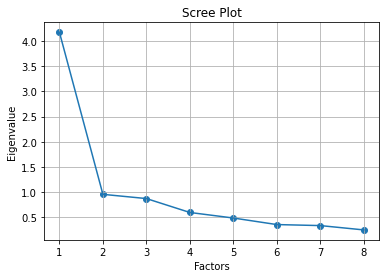

In [156]:
plt.scatter(range(1, items_sexdissa_without_nan_w6_f_df.shape[1]+1), ev_sexdissa_w6_f)
plt.plot(range(1, items_sexdissa_without_nan_w6_f_df.shape[1]+1), ev_sexdissa_w6_f)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

* sexdissa_w6_m

#### Exploratorio

>Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis

In [157]:
chi_square_value_sexdissa_w6_m,p_value_sexdissa_w6_m = calculate_bartlett_sphericity(items_sexdissa_without_nan_w6_m_df)

In [158]:
chi_square_value_sexdissa_w6_m,p_value_sexdissa_w6_m

(4119.885930316781, 0.0)

The test was statistically significant, indicating that the observed correlation matrix **is not** an identity matrix.

>Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [159]:
kmo_all_sexdissa_w6_m, Kmo_model_sexdissa_w6_m = calculate_kmo(items_sexdissa_without_nan_w6_m_df)

In [160]:
kmo_all_sexdissa_w6_m

array([0.83599007, 0.88546661, 0.86590756, 0.85817508, 0.89811555,
       0.8873534 , 0.90397801, 0.86927345, 0.88822539])

In [161]:
Kmo_model_sexdissa_w6_m

0.8777125078359397

In [162]:
fa_sexdissa_w6_m = FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=2, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [163]:
fa_sexdissa_w6_m.fit(items_sexdissa_without_nan_w6_m_df)

FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=2, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [164]:
ev_sexdissa_w6_m, v_sexdissa_w6_m = fa_sexdissa_w6_m.get_eigenvalues()

In [165]:
ev_sexdissa_w6_m

array([4.36119367, 1.23117005, 0.77732398, 0.59656571, 0.52108531,
       0.48937191, 0.40329002, 0.32247313, 0.29752622])

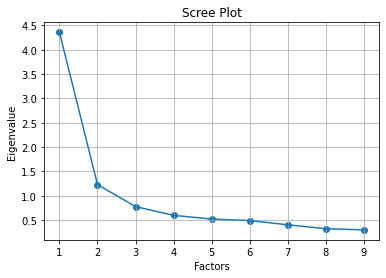

In [166]:
plt.scatter(range(1, items_sexdissa_without_nan_w6_m_df.shape[1]+1), ev_sexdissa_w6_m)
plt.plot(range(1, items_sexdissa_without_nan_w6_m_df.shape[1]+1), ev_sexdissa_w6_m)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

## 11) Normalizar

In [167]:
# https://www.it-swarm.dev/es/python/normalizar-columnas-de-datos-de-pandas./1049023341/

In [ ]:
min_max_scaler = preprocessing.scale()
x_scaled = min_max_scaler.fit_transform(x)
df = pandas.DataFrame(x_scaled)

In [ ]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

* Casp19 ola 6

In [ ]:
n_casp19_w6 = 

* Insatisfacción sexual ola 6 mujeres

In [187]:
n_sexdissa_w6_f = sexdissa_w6_f.values
sexdissa_w6_f_scaled = n_sexdissa_w6_f.min_max_scaler.fit_transform()
sexdissa_w6_f_scaled_df = pd.DataFrame(sexdissa_w6_f_scaled)

AttributeError: 'numpy.ndarray' object has no attribute 'min_max_scaler'

* Insatisfacción sexual ola 6 hombres

In [ ]:
n_sexdissa_w6_m =

* Multimorbilidad ola 6

* ad ola 6

* Casp19 ola 8

## ( ! ) Bases de datos juntadas

In [171]:
indager_df = w6_second_cleaned_df['indager']

* mujeres 

In [172]:
w8_w6_f_df = pd.DataFrame([sexdissa_w6_f, casp19_w6, isolation_w6_df, indager_df, casp19_w8])
w8_w6_f_df_t = w8_w6_f_df.transpose()
w8_w6_f_df_t.columns = ['sexdissa_w6_f', 'casp19_w6', 'isolation_w6_df', 'indager_df', 'casp19_w8']
w8_w6_f_df_t

,sexdissa_w6_f,casp19_w6,isolation_w6_df,indager_df,casp19_w8
idauniq,,,,,
100006.0,NaN,37.0,3.0,NaN,NaN
100007.0,NaN,50.0,1.0,NaN,36.0
100009.0,NaN,42.0,2.0,72.0,NaN
100012.0,NaN,NaN,NaN,NaN,51.0
100023.0,NaN,NaN,NaN,NaN,37.0
...,...,...,...,...,...
908465.0,NaN,NaN,NaN,NaN,54.0
908466.0,NaN,NaN,NaN,NaN,47.0
908468.0,NaN,NaN,NaN,NaN,46.0


* hombres

In [174]:
w8_w6_m_df = pd.DataFrame([sexdissa_w6_m, casp19_w6, isolation_w6_df, indager_df, casp19_w8])
w8_w6_m_df_t = w8_w6_m_df.transpose()
w8_w6_m_df_t.columns = ['sexdissa_w6_m', 'casp19_w6', 'isolation_w6_df', 'indager_df', 'casp19_w8']
w8_w6_m_df_t

,sexdissa_w6_m,casp19_w6,isolation_w6_df,indager_df,casp19_w8
idauniq,,,,,
100006.0,NaN,37.0,3.0,NaN,NaN
100007.0,NaN,50.0,1.0,NaN,36.0
100009.0,1.0,42.0,2.0,72.0,NaN
100012.0,NaN,NaN,NaN,NaN,51.0
100023.0,NaN,NaN,NaN,NaN,37.0
...,...,...,...,...,...
908465.0,NaN,NaN,NaN,NaN,54.0
908466.0,NaN,NaN,NaN,NaN,47.0
908468.0,NaN,NaN,NaN,NaN,46.0


### Eliminamos los nuevos de la ola 8 y los de la ola 6 que no se repiten en la ola 8

In [191]:
w8_w6_f_df_t.dropna()

,sexdissa_w6_f,casp19_w6,isolation_w6_df,indager_df,casp19_w8
idauniq,,,,,
100082.0,5.0,56.0,1.0,60.0,56.0
101544.0,9.0,36.0,1.0,68.0,32.0
103783.0,4.0,46.0,0.0,74.0,47.0
103801.0,6.0,46.0,1.0,61.0,49.0
103818.0,7.0,48.0,1.0,62.0,51.0
...,...,...,...,...,...
166081.0,0.0,51.0,1.0,51.0,50.0
166106.0,9.0,42.0,1.0,56.0,50.0
166111.0,1.0,38.0,2.0,52.0,37.0


In [192]:
w8_w6_f_df_t_without_nan = w8_w6_f_df_t.dropna()

In [193]:
w8_w6_m_df_t.dropna()

,sexdissa_w6_m,casp19_w6,isolation_w6_df,indager_df,casp19_w8
idauniq,,,,,
100054.0,20.0,17.0,3.0,64.0,28.0
101879.0,4.0,40.0,2.0,74.0,41.0
103699.0,1.0,48.0,1.0,64.0,44.0
103716.0,4.0,44.0,1.0,80.0,44.0
103769.0,10.0,27.0,1.0,80.0,31.0
...,...,...,...,...,...
166158.0,3.0,26.0,0.0,54.0,40.0
166164.0,1.0,40.0,2.0,61.0,32.0
166165.0,17.0,22.0,3.0,54.0,37.0


In [194]:
w8_w6_m_df_t_without_nan = w8_w6_m_df_t.dropna()

## 12) Regresión lineal múltiple

In [177]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [202]:
x1f = w8_w6_f_df_t_without_nan['sexdissa_w6_f']
x2f = w8_w6_f_df_t_without_nan['casp19_w6']
x3f = w8_w6_f_df_t_without_nan['isolation_w6_df']
x4f = w8_w6_f_df_t_without_nan['indager_df']
yf = w8_w6_f_df_t_without_nan['casp19_w8']

* mujeres

In [203]:
modf = smf.ols('yf ~ x1f +x2f + x3f + x4f', data=w8_w6_f_df_t_without_nan).fit()

In [204]:
print(modf.summary())

                            OLS Regression Results                            
Dep. Variable:                     yf   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     192.5
Date:                Thu, 03 Sep 2020   Prob (F-statistic):          3.23e-114
Time:                        12:46:24   Log-Likelihood:                -2417.1
No. Observations:                 772   AIC:                             4844.
Df Residuals:                     767   BIC:                             4867.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.8767      2.308      9.479      0.0

### Extraer los β estimados:

In [209]:
modf.params

Intercept    21.876725
x1f          -0.072409
x2f           0.696962
x3f          -0.393705
x4f          -0.109519
dtype: float64

#### Extraer el σ2 estimado:

In [211]:
modf.mse_resid

30.894421265242524

* hombres

In [205]:
ym = w8_w6_m_df_t_without_nan['casp19_w8']

x1m = w8_w6_m_df_t_without_nan['sexdissa_w6_m']
x2m = w8_w6_m_df_t_without_nan['casp19_w6']
x3m = w8_w6_m_df_t_without_nan['isolation_w6_df']
x4m = w8_w6_m_df_t_without_nan['indager_df']

In [207]:
modm = smf.ols('ym ~ x1m +x2m + x3m + x4m', data=w8_w6_m_df_t_without_nan).fit()

In [208]:
print(modm.summary())

                            OLS Regression Results                            
Dep. Variable:                     ym   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     186.5
Date:                Thu, 03 Sep 2020   Prob (F-statistic):          4.60e-115
Time:                        12:47:05   Log-Likelihood:                -2710.6
No. Observations:                 865   AIC:                             5431.
Df Residuals:                     860   BIC:                             5455.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.9748      2.116     10.386      0.0

### Extraer los β estimados:

In [212]:
modm.params

Intercept    21.974840
x1m          -0.022149
x2m           0.664185
x3m          -0.221833
x4m          -0.093237
dtype: float64

#### Extraer el σ2 estimado:

In [213]:
modm.mse_resid

31.034430823253505